<a href="https://colab.research.google.com/github/rocodoco20/AI1week/blob/main/cuda_psy_1Hweek.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

In [2]:
transform = transforms.ToTensor()

trainset = torchvision.datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

100%|██████████| 170M/170M [00:05<00:00, 30.5MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


##[MY CODE] Test data 준비하기 train False

50000
torch.Size([3, 32, 32]) 6


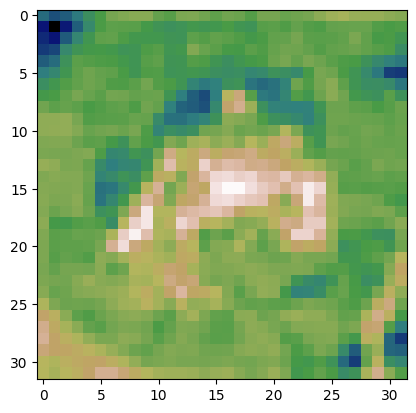

In [3]:
from matplotlib import pyplot as plt


print(len(trainset))
print(trainset[0][0].shape, trainset[0][1])
plt.imshow(trainset[0][0][0], cmap='gist_earth')

In [4]:
batch_size = 256

trainloader = torch.utils.data.DataLoader(
    trainset,
    batch_size=batch_size,
    shuffle=True
)

In [5]:
testset = torchvision.datasets.CIFAR10(
    root='./data',
    train=False,
    download=True,
    transform=transform
)

batch_size = 256

testDataLoader = torch.utils.data.DataLoader(
    testset,
    batch_size=batch_size,
    shuffle=False
)

Files already downloaded and verified


[MY CODE] Test data 준비하기 shuffle False

In [6]:
dataiter = iter(trainloader)
images, labels = next(dataiter)
print(images.shape, labels.shape)

torch.Size([256, 3, 32, 32]) torch.Size([256])


In [7]:
from torch import nn

class Model(nn.Module):
  def __init__(self, input_dim, n_dim):
    super().__init__()

    self.layer1 = nn.Linear(input_dim, n_dim)
    self.layer2 = nn.Linear(n_dim, n_dim)
    self.layer3 = nn.Linear(n_dim, 10) # Changed output dimension to 10 for CIFAR-10

    self.act = nn.LeakyReLU()

  def forward(self, x):
    x = torch.flatten(x, start_dim=1)
    x = self.act(self.layer1(x))
    x = self.act(self.layer2(x))
    x = self.layer3(x) # Removed activation from the last layer for logits

    return x


model = Model(32 * 32 * 3, 1024)

##[MY CODE] model = Model(32 * 32 * 3, 1024)으로 변경

- ## SGD와 Adam 성능 비교
    - 먼저 [Adam optimizer](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html)을 사용하여 학습하는 코드를 구현합니다.
    - (Plot 1) SGD와 Adam을 학습시킨 후 각각의 epoch에 대한 train 정확도를 plot합니다.

In [ ]:
from torch.optim import SGD

lr = 0.001
model = model.to('cuda')
criterion = nn.CrossEntropyLoss()
optimizer = SGD(model.parameters(), lr=lr)

In [ ]:
from torch.optim import Adam

lr = 0.001
model2 = model.to('cuda')
criterion2 = nn.CrossEntropyLoss()
optimizer2 = Adam(model2.parameters(), lr=lr)

In [12]:
def accuracy(model, dataloader):
    cnt = 0
    acc = 0

    for data in dataloader:
        inputs, labels = data
        inputs, labels = inputs.to('cuda'), labels.to('cuda')

        preds = model(inputs)
        preds = torch.argmax(preds, dim=-1)

        cnt += labels.shape[0]
        acc += (labels == preds).sum().item()

    return acc / cnt

##[LOG] SGD 로그

In [ ]:
sgd_train_accs, sgd_test_accs = [], []
n_epochs = 50
for epoch in range(n_epochs):
    total_loss = 0.0
    model.train()

    for data in trainloader:
        inputs, labels = data
        inputs, labels = inputs.to('cuda'), labels.to('cuda')

        optimizer.zero_grad()
        preds = model(inputs)
        loss = criterion(preds, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    # Epoch 끝난 후 Train/Test 정확도 측정
    model.eval()
    sgd_train_acc = accuracy(model, trainloader)
    sgd_test_acc = accuracy(model, testDataLoader)
    sgd_train_accs.append(sgd_train_acc)
    sgd_test_accs.append(sgd_test_acc)

    print(f"[LOG] SDG Epoch {epoch} | Loss: {total_loss:.4f} | Train Acc: {sgd_train_acc:.4f} | Test Acc: {sgd_test_acc:.4f}")

[LOG] SDG Epoch 0 | Loss: 450.2531 | Train Acc: 0.1176 | Test Acc: 0.1145
[LOG] SDG Epoch 1 | Loss: 447.9740 | Train Acc: 0.1648 | Test Acc: 0.1611
[LOG] SDG Epoch 2 | Loss: 446.0121 | Train Acc: 0.1748 | Test Acc: 0.1747
[LOG] SDG Epoch 3 | Loss: 444.1449 | Train Acc: 0.1821 | Test Acc: 0.1823
[LOG] SDG Epoch 4 | Loss: 442.2139 | Train Acc: 0.1931 | Test Acc: 0.1943
[LOG] SDG Epoch 5 | Loss: 440.1732 | Train Acc: 0.2068 | Test Acc: 0.2051
[LOG] SDG Epoch 6 | Loss: 437.9789 | Train Acc: 0.2172 | Test Acc: 0.2143
[LOG] SDG Epoch 7 | Loss: 435.6135 | Train Acc: 0.2302 | Test Acc: 0.2271
[LOG] SDG Epoch 8 | Loss: 433.0596 | Train Acc: 0.2362 | Test Acc: 0.2329
[LOG] SDG Epoch 9 | Loss: 430.3036 | Train Acc: 0.2420 | Test Acc: 0.2378
[LOG] SDG Epoch 10 | Loss: 427.4409 | Train Acc: 0.2492 | Test Acc: 0.2456
[LOG] SDG Epoch 11 | Loss: 424.4936 | Train Acc: 0.2541 | Test Acc: 0.2518
[LOG] SDG Epoch 12 | Loss: 421.5124 | Train Acc: 0.2524 | Test Acc: 0.2493
[LOG] SDG Epoch 13 | Loss: 418.5623

## [LOG] Adam 로그

In [ ]:
adam_train_accs, adam_test_accs = [], []
n_epochs = 50
for epoch in range(n_epochs):
    total_loss2 = 0.0
    model2.train()
    for data in trainloader:
        inputs, labels = data
        inputs, labels = inputs.to('cuda'), labels.to('cuda')

        optimizer2.zero_grad()
        preds2 = model2(inputs)
        loss = criterion2(preds2, labels)
        loss.backward()
        optimizer2.step()

        total_loss2 += loss.item()

    # Epoch 끝난 후 Train/Test 정확도 측정
    model.eval()
    adam_train_acc = accuracy(model2, trainloader)
    adam_test_acc = accuracy(model2, testDataLoader)
    adam_train_accs.append(adam_train_acc)
    adam_test_accs.append(adam_test_acc)

    print(f"[LOG] ADAM Epoch {epoch} | Loss: {total_loss2:.4f} | Train Acc: {adam_train_acc:.4f} | Test Acc: {adam_test_acc:.4f}")

[LOG] ADAM Epoch 0 | Loss: 364.7856 | Train Acc: 0.3529 | Test Acc: 0.3597
[LOG] ADAM Epoch 1 | Loss: 324.2925 | Train Acc: 0.4294 | Test Acc: 0.4242
[LOG] ADAM Epoch 2 | Loss: 308.7333 | Train Acc: 0.4390 | Test Acc: 0.4315
[LOG] ADAM Epoch 3 | Loss: 294.3516 | Train Acc: 0.4802 | Test Acc: 0.4649
[LOG] ADAM Epoch 4 | Loss: 284.8388 | Train Acc: 0.4795 | Test Acc: 0.4668
[LOG] ADAM Epoch 5 | Loss: 277.0136 | Train Acc: 0.4808 | Test Acc: 0.4570
[LOG] ADAM Epoch 6 | Loss: 269.3201 | Train Acc: 0.4988 | Test Acc: 0.4739
[LOG] ADAM Epoch 7 | Loss: 262.2081 | Train Acc: 0.5287 | Test Acc: 0.4898
[LOG] ADAM Epoch 8 | Loss: 256.1846 | Train Acc: 0.5456 | Test Acc: 0.5056
[LOG] ADAM Epoch 9 | Loss: 252.3857 | Train Acc: 0.5466 | Test Acc: 0.5031
[LOG] ADAM Epoch 10 | Loss: 244.5370 | Train Acc: 0.5578 | Test Acc: 0.5126
[LOG] ADAM Epoch 11 | Loss: 239.1454 | Train Acc: 0.5691 | Test Acc: 0.5136
[LOG] ADAM Epoch 12 | Loss: 235.5407 | Train Acc: 0.5870 | Test Acc: 0.5216
[LOG] ADAM Epoch 13 | 

## SGD와 Adam 성능 비교 PLOT

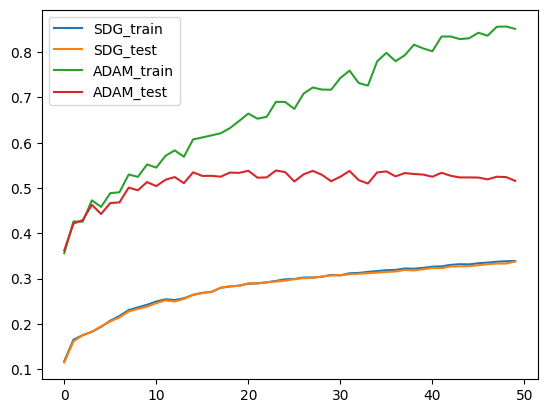

In [ ]:
import numpy as np

def plot_acc(sgd_train_accs, sgd_test_accs, adam_train_accs, adam_test_accs, label1='SDG_train', label2='SDG_test', label3='ADAM_train', label4='ADAM_test'):
  x = np.arange(len(sgd_train_accs))
  x2 = np.arange(len(adam_train_accs))
  plt.plot(x, sgd_train_accs, label=label1)
  plt.plot(x, sgd_test_accs, label=label2)
  plt.plot(x2, adam_train_accs, label=label3)
  plt.plot(x2, adam_test_accs, label=label4)
  plt.legend()
  plt.show()

plot_acc(sgd_train_accs, sgd_test_accs, adam_train_accs, adam_test_accs)

##- Leaky ReLU와 Sigmoid 성능 비교
    - Activation 함수가 `nn.Sigmoid`인 class를 새로 정의합니다.
    - (Plot 2) Adam optimizer를 가지고 sigmoid와 leaky ReLU 모델들을 학습한 후, epoch에 따른 train 정확도를 비교합니다.

In [8]:
from torch import nn

class Model2(nn.Module):
  def __init__(self, input_dim, n_dim):
    super().__init__()

    self.layer1 = nn.Linear(input_dim, n_dim)
    self.layer2 = nn.Linear(n_dim, n_dim)
    self.layer3 = nn.Linear(n_dim, 10) # Changed output dimension to 10

    self.act = nn.Sigmoid()

  def forward(self, x):
    x = torch.flatten(x, start_dim=1)
    x = self.act(self.layer1(x))
    x = self.act(self.layer2(x))
    x = self.layer3(x) # Removed sigmoid from the last layer

    return x


model3 = Model2(32 * 32 * 3, 1024)

In [9]:
from torch.optim import Adam

lr = 0.001
model2 = model.to('cuda')
optimizer2 = Adam(model2.parameters(), lr=lr)

In [10]:
from torch.optim import Adam

lr = 0.001
model3 = model3.to('cuda')
optimizer3 = Adam(model3.parameters(), lr=lr)

## [LOG] Sigmoid 로그

In [14]:
Sigmoid_train_accs, Sigmoid_test_accs = [], []

n_epochs = 50
# Define criterion3
criterion3 = nn.CrossEntropyLoss()

for epoch in range(n_epochs):
    # Sigmoid 모델 훈련
    total_loss3 = 0.0
    model3.train()
    for data in trainloader:
        inputs, labels = data

        # 라벨 확인 및 변환
        labels = labels.long()  # 라벨을 정수형으로 변환
        inputs, labels = inputs.to('cuda'), labels.to('cuda')

        optimizer3.zero_grad()
        preds3 = model3(inputs)
        loss = criterion3(preds3, labels)
        loss.backward()  # 여기서 CUDA 에러 발생 가능
        optimizer3.step()

        total_loss3 += loss.item()

    # Sigmoid 모델 정확도 측정
    with torch.no_grad():
      model3.eval()
      Sigmoid_train_acc = accuracy(model3, trainloader)
      Sigmoid_test_acc = accuracy(model3, testDataLoader)

    Sigmoid_train_accs.append(Sigmoid_train_acc)
    Sigmoid_test_accs.append(Sigmoid_test_acc)

    print(f"[LOG] Sigmoid Epoch {epoch} | Loss: {total_loss3:.4f} | Train Acc: {Sigmoid_train_acc:.4f} | Test Acc: {Sigmoid_test_acc:.4f}")


[LOG] Sigmoid Epoch 0 | Loss: 292.6942 | Train Acc: 0.4761 | Test Acc: 0.4565
[LOG] Sigmoid Epoch 1 | Loss: 285.7590 | Train Acc: 0.4817 | Test Acc: 0.4642
[LOG] Sigmoid Epoch 2 | Loss: 280.6835 | Train Acc: 0.4964 | Test Acc: 0.4770
[LOG] Sigmoid Epoch 3 | Loss: 276.6000 | Train Acc: 0.5119 | Test Acc: 0.4837
[LOG] Sigmoid Epoch 4 | Loss: 268.2369 | Train Acc: 0.5102 | Test Acc: 0.4762
[LOG] Sigmoid Epoch 5 | Loss: 263.5744 | Train Acc: 0.5317 | Test Acc: 0.5010
[LOG] Sigmoid Epoch 6 | Loss: 260.2507 | Train Acc: 0.5084 | Test Acc: 0.4735
[LOG] Sigmoid Epoch 7 | Loss: 255.3660 | Train Acc: 0.5444 | Test Acc: 0.4991
[LOG] Sigmoid Epoch 8 | Loss: 251.5462 | Train Acc: 0.5394 | Test Acc: 0.4893
[LOG] Sigmoid Epoch 9 | Loss: 247.2187 | Train Acc: 0.5623 | Test Acc: 0.5131
[LOG] Sigmoid Epoch 10 | Loss: 243.1340 | Train Acc: 0.5612 | Test Acc: 0.5041
[LOG] Sigmoid Epoch 11 | Loss: 239.7155 | Train Acc: 0.5583 | Test Acc: 0.5027
[LOG] Sigmoid Epoch 12 | Loss: 235.7659 | Train Acc: 0.5848 | 

In [15]:
adam_train_accs, adam_test_accs = [], []
criterion2 = nn.CrossEntropyLoss()
# ADAM 모델 훈련

for epoch in range(n_epochs):
    total_loss2 = 0.0
    model2.train()
    for data in trainloader:
      inputs, labels = data

      # 라벨 확인 및 변환
      labels = labels.long()  # 라벨을 정수형으로 변환
      inputs, labels = inputs.to('cuda'), labels.to('cuda')

      optimizer2.zero_grad()
      preds2 = model2(inputs)
      loss = criterion2(preds2, labels)
      loss.backward()  # 여기서 CUDA 에러 발생 가능
      optimizer2.step()

      total_loss2 += loss.item()

    # ADAM 모델 정확도 측정
    with torch.no_grad():
      model2.eval()
      adam_train_acc = accuracy(model2, trainloader)
      adam_test_acc = accuracy(model2, testDataLoader)

    adam_train_accs.append(adam_train_acc)
    adam_test_accs.append(adam_test_acc)

    print(f"[LOG] ADAM Epoch {epoch} | Loss: {total_loss2:.4f} | Train Acc: {adam_train_acc:.4f} | Test Acc: {adam_test_acc:.4f}")

[LOG] ADAM Epoch 0 | Loss: 364.6126 | Train Acc: 0.3861 | Test Acc: 0.3833
[LOG] ADAM Epoch 1 | Loss: 323.8170 | Train Acc: 0.4402 | Test Acc: 0.4367
[LOG] ADAM Epoch 2 | Loss: 303.8465 | Train Acc: 0.4645 | Test Acc: 0.4555
[LOG] ADAM Epoch 3 | Loss: 293.7471 | Train Acc: 0.4704 | Test Acc: 0.4584
[LOG] ADAM Epoch 4 | Loss: 283.3823 | Train Acc: 0.4896 | Test Acc: 0.4699
[LOG] ADAM Epoch 5 | Loss: 275.1940 | Train Acc: 0.5137 | Test Acc: 0.4877
[LOG] ADAM Epoch 6 | Loss: 268.9133 | Train Acc: 0.5234 | Test Acc: 0.4957
[LOG] ADAM Epoch 7 | Loss: 261.8115 | Train Acc: 0.5388 | Test Acc: 0.5088
[LOG] ADAM Epoch 8 | Loss: 256.3218 | Train Acc: 0.5324 | Test Acc: 0.4982
[LOG] ADAM Epoch 9 | Loss: 250.5223 | Train Acc: 0.5676 | Test Acc: 0.5248
[LOG] ADAM Epoch 10 | Loss: 244.4487 | Train Acc: 0.5742 | Test Acc: 0.5161
[LOG] ADAM Epoch 11 | Loss: 238.6508 | Train Acc: 0.5813 | Test Acc: 0.5142
[LOG] ADAM Epoch 12 | Loss: 233.0058 | Train Acc: 0.5799 | Test Acc: 0.5193
[LOG] ADAM Epoch 13 | 

## [plot] 결과확인

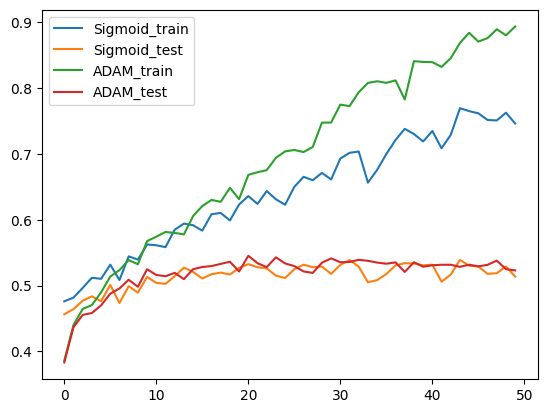

In [16]:
import numpy as np

def plot_acc(Sigmoid_train_accs, Sigmoid_test_accs, adam_train_accs, adam_test_accs, label1='Sigmoid_train', label2='Sigmoid_test', label3='ADAM_train', label4='ADAM_test'):
  x = np.arange(len(Sigmoid_train_accs))
  x2 = np.arange(len(adam_train_accs))
  plt.plot(x, Sigmoid_train_accs, label=label1)
  plt.plot(x, Sigmoid_test_accs, label=label2)
  plt.plot(x2, adam_train_accs, label=label3)
  plt.plot(x2, adam_test_accs, label=label4)
  plt.legend()
  plt.show()

plot_acc(Sigmoid_train_accs, Sigmoid_test_accs, adam_train_accs, adam_test_accs)